In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
list(enumerate(train.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration')]

In [4]:
list(enumerate(test.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'passenger_count'),
 (4, 'pickup_longitude'),
 (5, 'pickup_latitude'),
 (6, 'dropoff_longitude'),
 (7, 'dropoff_latitude'),
 (8, 'store_and_fwd_flag')]

#### Street network data

In [6]:
import osmnx as ox
ox.config(log_file=True, log_console=True, use_cache=True)

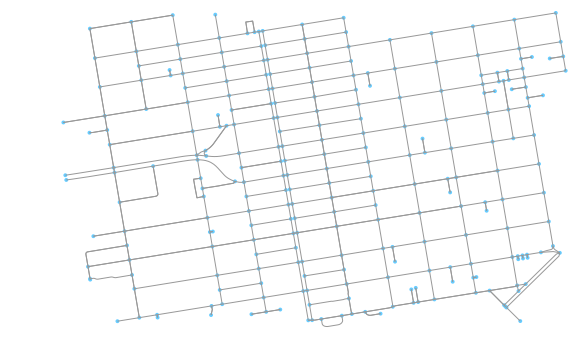

In [7]:
# example
# ----------------
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
G1 = ox.project_graph(G1)
fig, ax = ox.plot_graph(G1)

(40.76793670654297, -73.98215484619139)


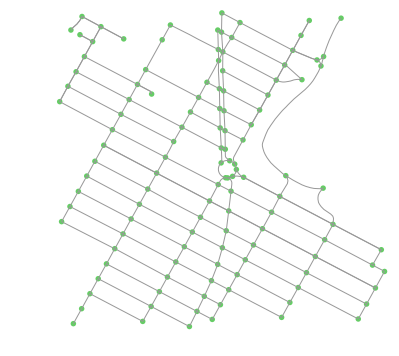

In [44]:
# get first point from training set
pickup_point = (train_gdf.geometry[0].y, train_gdf.geometry[0].x)
print pickup_point

# create network from point, inside bounding box of N, S, E, W each 750m from point
local_graph = ox.graph_from_point(pickup_point, distance=750, distance_type='bbox', network_type='drive')
local_graph = ox.project_graph(local_graph)
fig, ax = ox.plot_graph(local_graph, node_size=30, node_color='#66cc66')

In [45]:
stats = ox.basic_stats(local_graph)
stats

{'circuity_avg': 1.5386062670647417e-05,
 'count_intersections': 120,
 'edge_density_km': None,
 'edge_length_avg': 131.04356846587473,
 'edge_length_total': 29484.802904821816,
 'intersection_density_km': None,
 'k_avg': 3.658536585365854,
 'm': 225,
 'n': 123,
 'node_density_km': None,
 'self_loop_proportion': 0.0,
 'street_density_km': None,
 'street_length_avg': 130.5310980798852,
 'street_length_total': 25845.157419817268,
 'street_segments_count': 198,
 'streets_per_node_avg': 3.6747967479674797,
 'streets_per_node_counts': {0: 0, 1: 3, 2: 1, 3: 31, 4: 87, 5: 0, 6: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.024390243902439025,
  2: 0.008130081300813009,
  3: 0.25203252032520324,
  4: 0.7073170731707317,
  5: 0.0,
  6: 0.008130081300813009}}

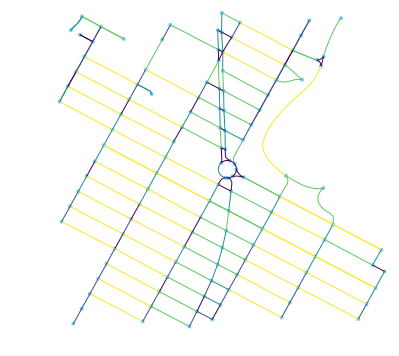

(<matplotlib.figure.Figure at 0x23e1dea90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23df76a50>)

In [46]:
# color edges by length; this type of color coding only seems to work for continuous attributes from osm
ec = ox.get_edge_colors_by_attr(local_graph, attr='length')
ox.plot_graph(local_graph, edge_color=ec)

In [47]:
# show osm data/attributes for the geometry obtained
local_graph.edges(keys=True, data=True)[:5]

[(42450434,
  42445033,
  0,
  {'geometry': <shapely.geometry.linestring.LineString at 0x23e013b10>,
   'highway': u'secondary',
   'lanes': u'4',
   'length': 273.06840633727234,
   'name': u'West 54th Street',
   'oneway': True,
   'osmid': 195743211}),
 (42450434,
  42440966,
  0,
  {'geometry': <shapely.geometry.linestring.LineString at 0x23e013ad0>,
   'highway': u'primary',
   'length': 81.349064499405472,
   'name': u'10th Avenue',
   'oneway': True,
   'osmid': 195743301}),
 (42430981,
  42454120,
  0,
  {'highway': u'residential',
   'length': 66.390486481107658,
   'name': u'West 62nd Street',
   'oneway': False,
   'osmid': 5672398}),
 (42430981,
  42421985,
  0,
  {'geometry': <shapely.geometry.linestring.LineString at 0x23e013fd0>,
   'highway': u'secondary',
   'length': 79.676958407430504,
   'name': u'West End Avenue',
   'oneway': False,
   'osmid': [420894368, 420894369, 420894363]}),
 (42430981,
  42430983,
  0,
  {'geometry': <shapely.geometry.linestring.LineString 

In [48]:
# create a gdf from the osm attributes and get the columns to show what the attributes are
edge_attributes = ox.graph_to_gdfs(local_graph, nodes=False).columns
print(edge_attributes)

Index([u'access', u'bridge', u'geometry', u'highway', u'key', u'lanes',
       u'length', u'maxspeed', u'name', u'oneway', u'osmid', u'tunnel', u'u',
       u'v', u'width'],
      dtype='object')


In [49]:
# simply create the gdf
edge_attr_data = ox.graph_to_gdfs(local_graph, nodes=False)
edge_attr_data.head()

,access,bridge,geometry,highway,key,lanes,length,maxspeed,name,oneway,osmid,tunnel,u,v,width
0,NaN,NaN,LINESTRING (585244.5675561909 4513403.32720782...,secondary,0,4,273.068406,NaN,West 54th Street,True,195743211,NaN,42450434,42445033,NaN
1,NaN,NaN,LINESTRING (585244.5675561909 4513403.32720782...,primary,0,NaN,81.349064,NaN,10th Avenue,True,195743301,NaN,42450434,42440966,NaN
2,NaN,NaN,LINESTRING (585309.9476036938 4514104.69793344...,residential,0,NaN,66.390486,NaN,West 62nd Street,False,5672398,NaN,42430981,42454120,NaN
3,NaN,NaN,LINESTRING (585309.9476036938 4514104.69793344...,secondary,0,NaN,79.676958,NaN,West End Avenue,False,"[420894368, 420894369, 420894363]",NaN,42430981,42421985,NaN
4,NaN,NaN,LINESTRING (585309.9476036938 4514104.69793344...,secondary,0,NaN,79.574821,NaN,West End Avenue,False,"[420894362, 420894366]",NaN,42430981,42430983,NaN


In [50]:
# extended stats
ext_stats = ox.stats.extended_stats(local_graph, bc=True, cc=True)

In [51]:
ext_stats.viewkeys()

dict_keys(['closeness_centrality_avg', 'closeness_centrality', 'clustering_coefficient', 'betweenness_centrality_avg', 'pagerank_min', 'betweenness_centrality', 'avg_weighted_neighbor_degree', 'clustering_coefficient_avg', 'avg_weighted_neighbor_degree_avg', 'avg_neighbor_degree', 'pagerank_min_node', 'pagerank_max', 'avg_neighbor_degree_avg', 'clustering_coefficient_weighted', 'clustering_coefficient_weighted_avg', 'degree_centrality', 'pagerank', 'pagerank_max_node', 'degree_centrality_avg'])

In [52]:
# betweennes centrality may be a good feature to use...

# avg betweennes score for all nodes in the local graph, relative just to the rest of the local graph
ext_stats['betweenness_centrality_avg']

0.0645460823934889

In [53]:
# get nodes for a local graph around a pickup point
# this can be useful for creating subgraphs from the larger city network (see below)
local_nodes = local_graph.nodes()

In [54]:
# create network for all NYC
nyc = ox.graph_from_place('New York, New York, USA')
nyc_projected = ox.project_graph(nyc)
fig, ax = ox.plot_graph(nyc_projected)

KeyboardInterrupt: 

In [ ]:
# save to graphml for future use
ox.save_graphml(nyc_projected, filename='data/nyc_projected.graphml')

In [ ]:
# mn = ox.graph_from_place('Manhattan, New York, USA', network_type='drive')
# mn_projected = ox.project_graph(mn)
# fig, ax = ox.plot_graph(mn_projected)

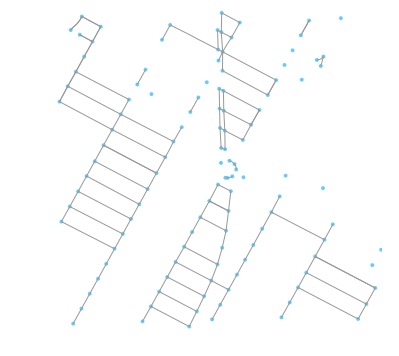

(<matplotlib.figure.Figure at 0x1c2a8f650>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2080b3390>)

In [51]:
subgraph = nyc.subgraph(local_nodes)
subgraph = ox.project_graph(subgraph)
ox.plot_graph(subgraph)